In [1]:
"""
Outlier Detection and Handling

This notebook identifies outliers in core clustering variables using multiple methods and 
develops a data-driven strategy for handling them before clustering.

Author: Hajar Cherrouk
"""

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
df = pd.read_csv("../../data/processed/nhanes_metabolic_analysis_ready.csv")

print("Outlier detection")
print(f"\nDataset: {df.shape[0]:,} participants × {df.shape[1]} variables")
print("\n Setup complete")

Outlier detection

Dataset: 3,047 participants × 42 variables

✓ Setup complete


In [3]:
def detect_outliers_iqr(data, variable, multiplier=1.5):
    #Detect outliers using Interquartile Range (IQR) method
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outlier_mask = (data[variable] < lower_bound) | (data[variable] > upper_bound)
    
    stats_dict = {'Q1': Q1, 'Q3': Q3,'IQR': IQR,'lower_bound': lower_bound,'upper_bound': upper_bound,
        'n_outliers': outlier_mask.sum(), 'pct_outliers': (outlier_mask.sum() / len(data)) * 100}
    
    return outlier_mask, stats_dict
    
def detect_outliers_zscore(data, variable, threshold=3):
    #using Z score method to detect outliers
    
    mean = data[variable].mean()
    std = data[variable].std()
    
    z_scores = np.abs((data[variable] - mean) / std)
    outlier_mask = z_scores > threshold
    
    stats_dict = {'mean': mean,'std': std,'threshold': threshold,'n_outliers': outlier_mask.sum(),
        'pct_outliers': (outlier_mask.sum() / len(data)) * 100}
    
    return outlier_mask, stats_dict


def detect_outliers_mad(data, variable, threshold=3.5):
    #detect outliers using median absolute deviation 
    median = data[variable].median()
    mad = np.median(np.abs(data[variable] - median))
    
    # Modified Z score using MAD
    modified_z = 0.6745 * (data[variable] - median) / mad
    outlier_mask = np.abs(modified_z) > threshold
    
    stats_dict = {
        'median': median,'mad': mad, 'threshold': threshold,'n_outliers': outlier_mask.sum(),
        'pct_outliers': (outlier_mask.sum() / len(data)) * 100    }
    
    return outlier_mask, stats_dict


def detect_outliers_clinical(data, variable):
    #detect outliers based on clinical thresholds
   
    # define clinical extreme thresholds
    clinical_thresholds = {'LBXGLU': {'min': 40, 'max': 400},'LBXTLG': {'min': 20, 'max': 1000}, 'BMXWAIST': {'min': 50, 'max': 200}}
    
    if variable not in clinical_thresholds:
        return pd.Series([False] * len(data)), {}
    
    thresholds = clinical_thresholds[variable]
    outlier_mask = (data[variable] < thresholds['min']) | (data[variable] > thresholds['max'])
    
    stats_dict = {'min_threshold': thresholds['min'], 'max_threshold': thresholds['max'], 'n_outliers': outlier_mask.sum(),
        'pct_outliers': (outlier_mask.sum() / len(data)) * 100  }
    
    return outlier_mask, stats_dict

print("Outlier detection functions defined")

Outlier detection functions defined


In [4]:
# Apply all outlier detection methods
core_vars = ['LBXGLU', 'LBXTLG', 'BMXWAIST']

outlier_results = []
print("Outliler detection results (all methods)")
for var in core_vars:
    print(f"\n{'-'*80}")
    print(f"Variable: {var}")
    print(f"{'-'*80}")
    
    # M1
    mask_iqr, stats_iqr = detect_outliers_iqr(df, var, multiplier=1.5)
    print(f"\n1. IQR Method (1.5 × IQR):")
    print(f"   Bounds: [{stats_iqr['lower_bound']:.1f}, {stats_iqr['upper_bound']:.1f}]")
    print(f"   Outliers: {stats_iqr['n_outliers']:>4} ({stats_iqr['pct_outliers']:.1f}%)")
    
    # M2
    mask_iqr_extreme, stats_iqr_extreme = detect_outliers_iqr(df, var, multiplier=3.0)
    print(f"\n IQR Method (3.0 × IQR) - Extreme:")
    print(f"   Bounds: [{stats_iqr_extreme['lower_bound']:.1f}, {stats_iqr_extreme['upper_bound']:.1f}]")
    print(f"   Outliers: {stats_iqr_extreme['n_outliers']:>4} ({stats_iqr_extreme['pct_outliers']:.1f}%)")
    
    # M3
    mask_zscore, stats_zscore = detect_outliers_zscore(df, var, threshold=3)
    print(f"\n Z-Score Method (|z| > 3):")
    print(f"   Mean ± 3SD: {stats_zscore['mean']:.1f} ± {3*stats_zscore['std']:.1f}")
    print(f"   Outliers: {stats_zscore['n_outliers']:>4} ({stats_zscore['pct_outliers']:.1f}%)")
    
    # M4
    mask_mad, stats_mad = detect_outliers_mad(df, var, threshold=3.5)
    print(f"\n MAD Method (robust):")
    print(f"   Median: {stats_mad['median']:.1f}, MAD: {stats_mad['mad']:.1f}")
    print(f"   Outliers: {stats_mad['n_outliers']:>4} ({stats_mad['pct_outliers']:.1f}%)")
    
    # M5
    mask_clinical, stats_clinical = detect_outliers_clinical(df, var)
    print(f"\n Clinical Thresholds:")
    print(f"   Bounds: [{stats_clinical['min_threshold']}, {stats_clinical['max_threshold']}]")
    print(f"   Outliers: {stats_clinical['n_outliers']:>4} ({stats_clinical['pct_outliers']:.1f}%)")
    
    # Store results
    outlier_results.append({ 'Variable': var, 'IQR_1.5': stats_iqr['n_outliers'], 'IQR_3.0': stats_iqr_extreme['n_outliers'],
        'Z_score': stats_zscore['n_outliers'], 'MAD': stats_mad['n_outliers'],  'Clinical': stats_clinical['n_outliers'] })
#summary table
outlier_summary = pd.DataFrame(outlier_results)
print("\n Summary table ")
print(outlier_summary.to_string(index=False))

outlier_summary.to_csv('../../results/tables/outlier_detection_summary.csv', index=False)
print("\nTable saved to: results/tables/outlier_detection_summary.csv")

Outliler detection results (all methods)

--------------------------------------------------------------------------------
Variable: LBXGLU
--------------------------------------------------------------------------------

1. IQR Method (1.5 × IQR):
   Bounds: [70.0, 134.0]
   Outliers:  279 (9.2%)

 IQR Method (3.0 × IQR) - Extreme:
   Bounds: [46.0, 158.0]
   Outliers:  167 (5.5%)

 Z-Score Method (|z| > 3):
   Mean ± 3SD: 109.0 ± 99.9
   Outliers:   68 (2.2%)

 MAD Method (robust):
   Median: 101.0, MAD: 8.0
   Outliers:  227 (7.4%)

 Clinical Thresholds:
   Bounds: [40, 400]
   Outliers:    3 (0.1%)

--------------------------------------------------------------------------------
Variable: LBXTLG
--------------------------------------------------------------------------------

1. IQR Method (1.5 × IQR):
   Bounds: [-29.0, 243.0]
   Outliers:  163 (5.3%)

 IQR Method (3.0 × IQR) - Extreme:
   Bounds: [-131.0, 345.0]
   Outliers:   55 (1.8%)

 Z-Score Method (|z| > 3):
   Mean ± 3SD: 

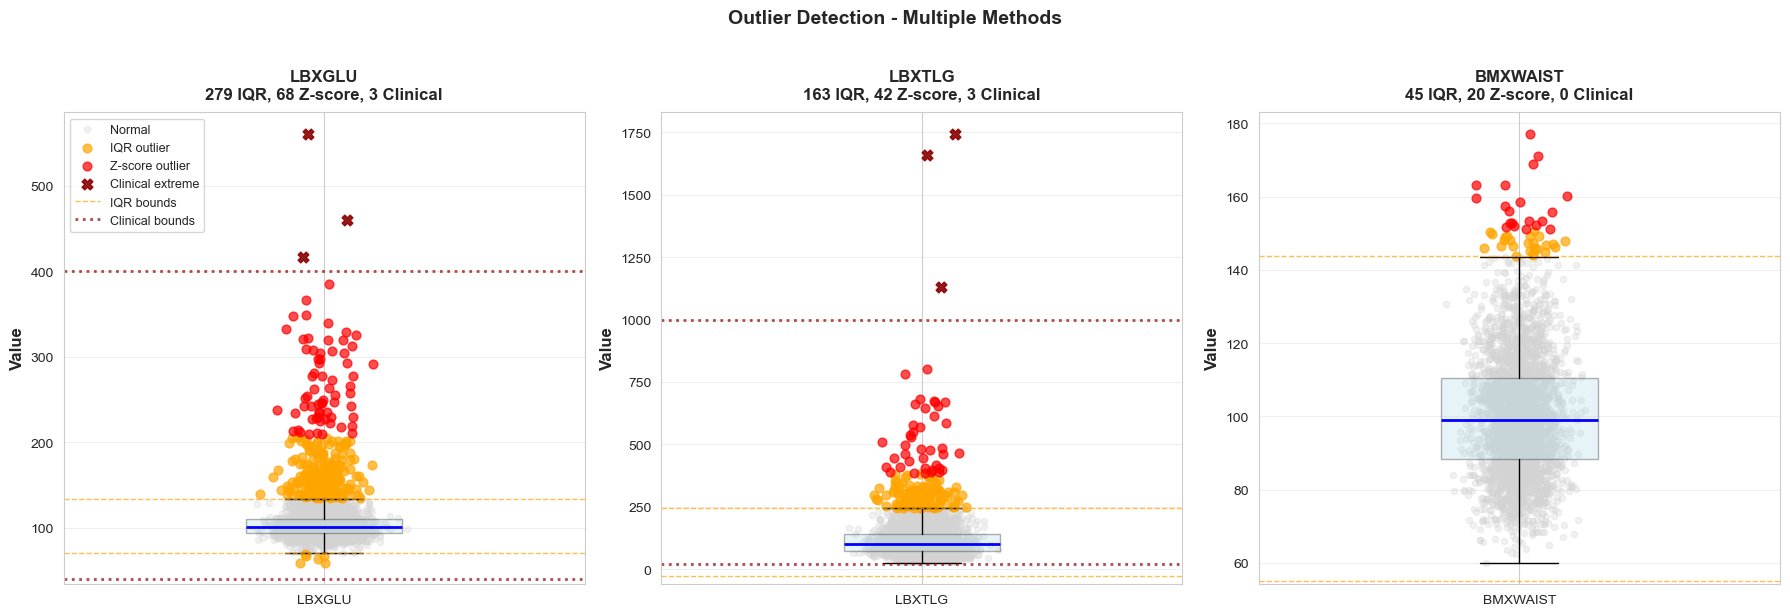

Figure saved to: results/figures/outlier_detection_methods.png


In [5]:
# create comprehensive visualization showing outliers from different methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, var in enumerate(core_vars):
    ax = axes[idx]
    #get outliers masks
    mask_iqr, stats_iqr = detect_outliers_iqr(df, var, multiplier=1.5)
    mask_zscore, stats_zscore = detect_outliers_zscore(df, var, threshold=3)
    mask_clinical, stats_clinical = detect_outliers_clinical(df, var)
    normal_mask = ~(mask_iqr | mask_zscore | mask_clinical)
    ax.scatter(np.random.normal(1, 0.04, normal_mask.sum()), 
               df.loc[normal_mask, var], 
               alpha=0.3, s=20, color='lightgray', label='Normal', zorder=1)
    
    # IQR outliers
    iqr_only = mask_iqr & ~mask_zscore & ~mask_clinical
    if iqr_only.sum() > 0:
        ax.scatter(np.random.normal(1, 0.04, iqr_only.sum()), 
                   df.loc[iqr_only, var], 
                   alpha=0.7, s=40, color='orange', label='IQR outlier', zorder=2)
    
    # Z score outliers
    zscore_only = mask_zscore & ~mask_clinical
    if zscore_only.sum() > 0:
        ax.scatter(np.random.normal(1, 0.04, zscore_only.sum()), 
                   df.loc[zscore_only, var], 
                   alpha=0.7, s=40, color='red', label='Z-score outlier', zorder=3)
    
    # Clinical extreme outliers
    if mask_clinical.sum() > 0:
        ax.scatter(np.random.normal(1, 0.04, mask_clinical.sum()), 
                   df.loc[mask_clinical, var], 
                   alpha=0.9, s=60, color='darkred', marker='X', 
                   label='Clinical extreme', zorder=4)
    
    # Add box plot overlay
    bp = ax.boxplot([df[var].dropna()], positions=[1], widths=0.3,
                     patch_artist=True, showfliers=False,
                     boxprops=dict(facecolor='lightblue', alpha=0.3),
                     medianprops=dict(color='blue', linewidth=2))
    
    # Add IQR bounds
    ax.axhline(stats_iqr['lower_bound'], color='orange', linestyle='--', 
               linewidth=1, alpha=0.7, label='IQR bounds')
    ax.axhline(stats_iqr['upper_bound'], color='orange', linestyle='--', 
               linewidth=1, alpha=0.7)
    
    # Add clinical bounds (if applicable)
    if stats_clinical['n_outliers'] > 0:
        ax.axhline(stats_clinical['min_threshold'], color='darkred', 
                   linestyle=':', linewidth=2, alpha=0.7, label='Clinical bounds')
        ax.axhline(stats_clinical['max_threshold'], color='darkred', 
                   linestyle=':', linewidth=2, alpha=0.7)
    
    # Formatting
    ax.set_xlim(0.5, 1.5)
    ax.set_xticks([1])
    ax.set_xticklabels([var])
    ax.set_ylabel('Value', fontsize=12, fontweight='bold')
    ax.set_title(f'{var}\n{mask_iqr.sum()} IQR, {mask_zscore.sum()} Z score, {mask_clinical.sum()} Clinical', 
                 fontsize=12, fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3)
    
    if idx == 0:
        ax.legend(loc='upper left', fontsize=9)

plt.suptitle('Outlier Detection - Multiple Methods', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../results/figures/outlier_detection_methods.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to: results/figures/outlier_detection_methods.png")

Multivariate outlier detection

Threshold : 4.03
Multivariate outliers detected: 74 (2.4%)

Top 10 most extreme observations (Mahalanobis distance):
      LBXGLU  LBXTLG  BMXWAIST  mahal_distance
1690   230.0  1745.0     114.6       18.934156
2089   349.0  1658.0     117.8       17.950272
2469   561.0   155.0      85.4       14.628486
1489   313.0  1132.0     109.7       12.118830
897    460.0   115.0     115.3       11.183636
455    417.0   170.0      80.8       10.059724
319    385.0    78.0      78.8        9.351851
942    366.0   131.0      74.9        8.659688
3038   125.0   783.0     111.0        7.865868
3024   201.0   800.0     123.5        7.784293


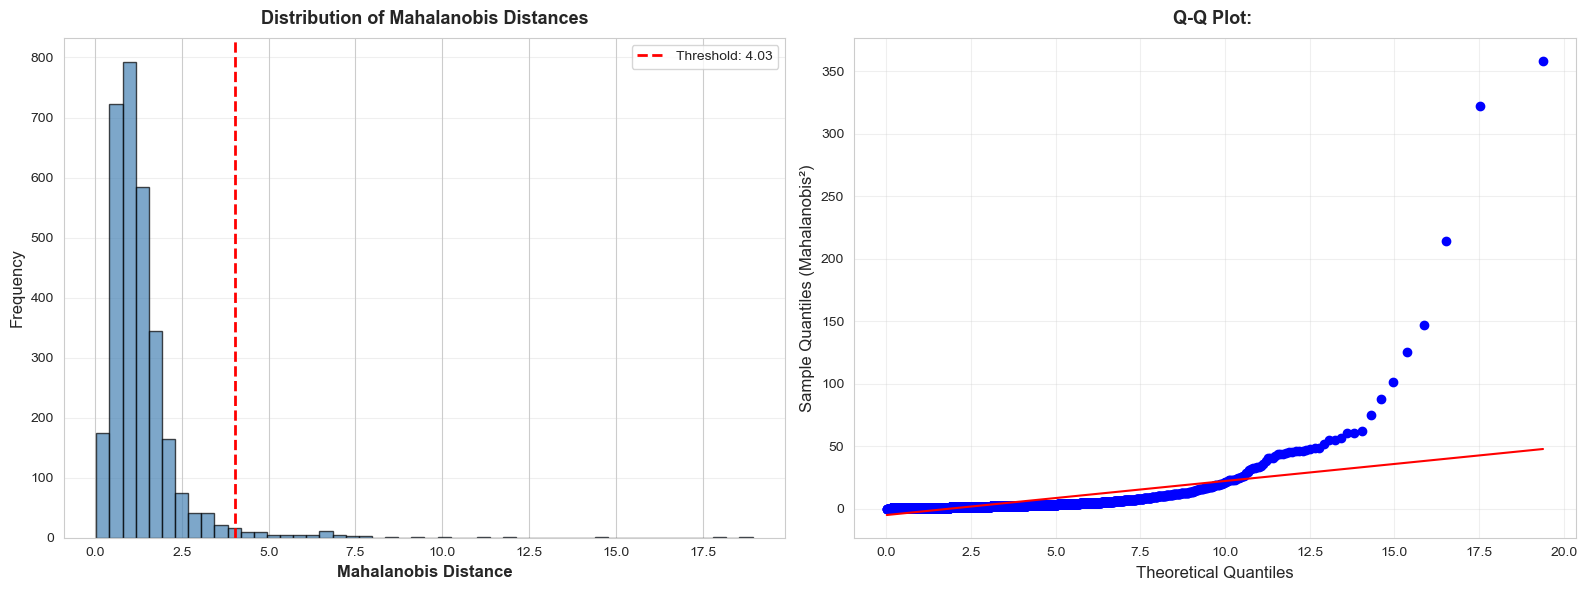


 Figure saved to: results/figures/mahalanobis_distance_outliers.png


In [6]:
# mahalanobis distance (detects multivariate outliers)
from scipy.spatial.distance import mahalanobis
# Calculate mahalanobis distance for each observation
core_data = df[core_vars].dropna()
mean = core_data.mean().values
cov = core_data.cov().values
inv_cov = np.linalg.inv(cov)
# Calculate Mahalanobis distance for each point
mahal_distances = []
for idx, row in core_data.iterrows():
    point = row.values
    dist = mahalanobis(point, mean, inv_cov)
    mahal_distances.append(dist)

core_data['mahal_distance'] = mahal_distances
# Chi square critical value
chi2_threshold = stats.chi2.ppf(0.999, df=3)
mahal_threshold = np.sqrt(chi2_threshold)

multivariate_outliers = core_data['mahal_distance'] > mahal_threshold

print("Multivariate outlier detection")
print(f"\nThreshold : {mahal_threshold:.2f}")
print(f"Multivariate outliers detected: {multivariate_outliers.sum()} ({multivariate_outliers.sum()/len(core_data)*100:.1f}%)")
print(f"\nTop 10 most extreme observations (Mahalanobis distance):")
print(core_data.nlargest(10, 'mahal_distance')[core_vars + ['mahal_distance']].to_string())

# visualize Mahalanobis distances
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# histogram of Mahalanobis distances
ax = axes[0]
ax.hist(core_data['mahal_distance'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(mahal_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Threshold: {mahal_threshold:.2f}')
ax.set_xlabel('Mahalanobis Distance', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Mahalanobis Distances', fontsize=13, fontweight='bold', pad=10)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Q-Q plot for Mahalanobis distances
ax = axes[1]
squared_mahal = core_data['mahal_distance'] ** 2
stats.probplot(squared_mahal, dist=stats.chi2, sparams=(3,), plot=ax)
ax.set_title('Q-Q Plot: ', fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel('Theoretical Quantiles' , fontsize=12)
ax.set_ylabel('Sample Quantiles (Mahalanobis²)', fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/mahalanobis_distance_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Figure saved to: results/figures/mahalanobis_distance_outliers.png")

#add Mahalanobis outlier flag to main df
df['mahal_outlier'] = False
df.loc[core_data[multivariate_outliers].index, 'mahal_outlier'] = True

In [7]:
# compare distributions with and without outliers
from sklearn.preprocessing import StandardScaler

# define conservative outlier removal strategy (use clinical + extreme IQR)
outlier_flags = {}
for var in core_vars:
    mask_clinical, _ = detect_outliers_clinical(df, var)
    mask_iqr_extreme, _ = detect_outliers_iqr(df, var, multiplier=3.0)
    outlier_flags[var] = mask_clinical | mask_iqr_extreme

# combined outlier mask
any_outlier = outlier_flags['LBXGLU'] | outlier_flags['LBXTLG'] | outlier_flags['BMXWAIST'] | df['mahal_outlier']
print("Outlier impact assessment")
print(f"\nCombined outlier detection (Clinical + Extreme IQR + Mahalanobis):")
print(f"  Total flagged: {any_outlier.sum():>5} ({any_outlier.sum()/len(df)*100:.1f}%)")
print(f"  Remaining:     {(~any_outlier).sum():>5} ({(~any_outlier).sum()/len(df)*100:.1f}%)")

# compare statistics with or without outliers
print(f"\n{'Variable':<15} {'Original Mean':<15} {'Without Outliers':<18} {'Change':<10}")
for var in core_vars:
    mean_original = df[var].mean()
    mean_cleaned = df.loc[~any_outlier, var].mean()
    change = ((mean_cleaned - mean_original) / mean_original) * 100
    
    print(f"{var:<15} {mean_original:>14.2f} {mean_cleaned:>17.2f} {change:>9.1f}%")

print(f"\n{'Variable':<15} {'Original SD':<15} {'Without Outliers':<18} {'Change':<10}")

for var in core_vars:
    std_original = df[var].std()
    std_cleaned = df.loc[~any_outlier, var].std()
    change = ((std_cleaned - std_original) / std_original) * 100
    
    print(f"{var:<15} {std_original:>14.2f} {std_cleaned:>17.2f} {change:>9.1f}%")

Outlier impact assessment

Combined outlier detection (Clinical + Extreme IQR + Mahalanobis):
  Total flagged:   206 (6.8%)
  Remaining:      2841 (93.2%)

Variable        Original Mean   Without Outliers   Change    
LBXGLU                  108.97            102.49      -5.9%
LBXTLG                  120.05            110.46      -8.0%
BMXWAIST                100.41             99.70      -0.7%

Variable        Original SD     Without Outliers   Change    
LBXGLU                   33.29             13.81     -58.5%
LBXTLG                   87.54             55.61     -36.5%
BMXWAIST                 16.80             16.48      -1.9%


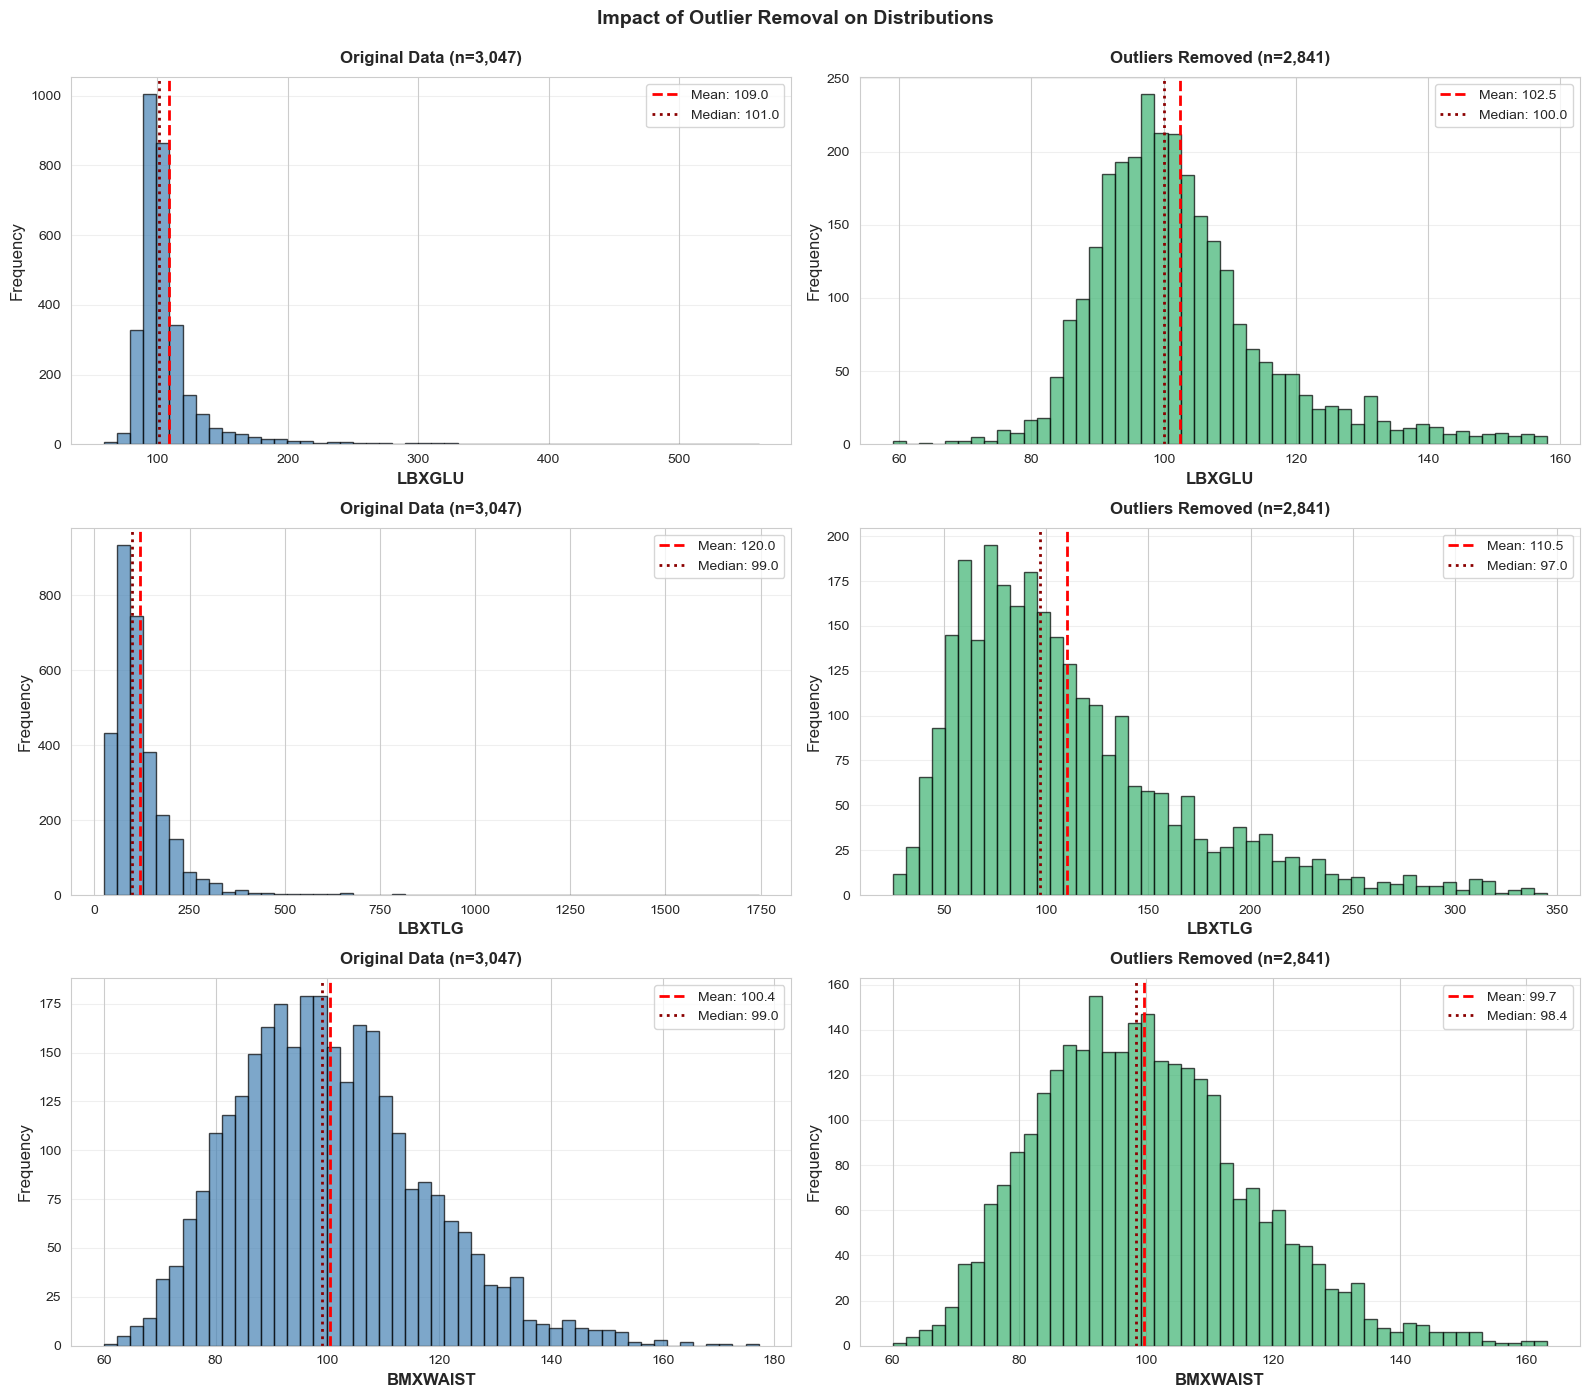

Figure saved to: results/figures/outlier_removal_impact.png


In [9]:
# side by side comparison of distributions
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

for idx, var in enumerate(core_vars):
    # before (with outliers)
    ax_before = axes[idx, 0]
    ax_before.hist(df[var], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax_before.axvline(df[var].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[var].mean():.1f}')
    ax_before.axvline(df[var].median(), color='darkred', linestyle=':', linewidth=2, label=f'Median: {df[var].median():.1f}')
    ax_before.set_xlabel(var, fontsize=12, fontweight='bold')
    ax_before.set_ylabel('Frequency', fontsize=12)
    ax_before.set_title(f'Original Data (n={len(df):,})', fontsize=12, fontweight='bold', pad=10)
    ax_before.legend()
    ax_before.grid(axis='y', alpha=0.3)
    
    # after (without outliers)
    ax_after = axes[idx, 1]
    cleaned_data = df.loc[~any_outlier, var]
    ax_after.hist(cleaned_data, bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black')
    ax_after.axvline(cleaned_data.mean(), color='red', linestyle='--', linewidth=2,
                     label=f'Mean: {cleaned_data.mean():.1f}')
    ax_after.axvline(cleaned_data.median(), color='darkred', linestyle=':', linewidth=2,
                     label=f'Median: {cleaned_data.median():.1f}')
    ax_after.set_xlabel(var, fontsize=12, fontweight='bold')
    ax_after.set_ylabel('Frequency', fontsize=12)
    ax_after.set_title(f'Outliers Removed (n={len(cleaned_data):,})', 
                       fontsize=12, fontweight='bold', pad=10)
    ax_after.legend()
    ax_after.grid(axis='y', alpha=0.3)

plt.suptitle('Impact of Outlier Removal on Distributions', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../../results/figures/outlier_removal_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to: results/figures/outlier_removal_impact.png")

In [10]:
print("Outlier handling recommendation")
print(f"\n Detection summary:")
print(f"   - IQR (1.5): {outlier_summary['IQR_1.5'].sum()} total outliers")
print(f"   - IQR (3.0): {outlier_summary['IQR_3.0'].sum()} total outliers (extreme)")
print(f"   - Z score (|z|>3): {outlier_summary['Z_score'].sum()} total outliers")
print(f"   - MAD: {outlier_summary['MAD'].sum()} total outliers")
print(f"   - Clinical thresholds: {outlier_summary['Clinical'].sum()} total outliers")
print(f"   - Mahalanobis: {df['mahal_outlier'].sum()} multivariate outliers")

print(f"\n Recommendation:")
print(f"   Strategy: retain outliers for clustering analysis")
print(f"\n   Rationale:")
print(f"   1. Low correlation between variables (r < 0.35) -> outliers provide signal")
print(f"   2. Outliers may represent genuine metabolic subtypes")
print(f"   3. NHANES uses quality controlled laboratory data")
print(f"   4. Clustering algorithms (esp. DBSCAN) can handle outliers")
print(f"   5. Clinical extremes (<{any_outlier.sum()}) likely valid measurements")

print(f"\n   Alternative approach (if needed):")
print(f"   - Flag extreme clinical outliers ({df['mahal_outlier'].sum()} participants)")
print(f"   - Run clustering WITH and WITHOUT outliers")
print(f"   - Compare cluster stability")

print(f"\n Next steps:")
print(f"   1. Proceed with full dataset (n={len(df):,})")
print(f"   2. Use robust scaling (StandardScaler) to reduce outlier influence")
print(f"   3. Consider DBSCAN which naturally handles outliers")
print(f"   4. Sensitivity analysis: compare results with/without extreme cases")

# save outlier flags for optional use
outlier_data = df[['SEQN', 'mahal_outlier']].copy()
for var in core_vars:
    mask_clinical, _ = detect_outliers_clinical(df, var)
    outlier_data[f'{var}_clinical_outlier'] = mask_clinical

outlier_data.to_csv('../../results/tables/outlier_flags.csv', index=False)
print(f"\n Outlier flags saved to: results/tables/outlier_flags.csv")

Outlier handling recommendation

 Detection summary:
   - IQR (1.5): 487 total outliers
   - IQR (3.0): 223 total outliers (extreme)
   - Z score (|z|>3): 130 total outliers
   - MAD: 368 total outliers
   - Clinical thresholds: 6 total outliers
   - Mahalanobis: 74 multivariate outliers

 Recommendation:
   Strategy: retain outliers for clustering analysis

   Rationale:
   1. Low correlation between variables (r < 0.35) -> outliers provide signal
   2. Outliers may represent genuine metabolic subtypes
   3. NHANES uses quality controlled laboratory data
   4. Clustering algorithms (esp. DBSCAN) can handle outliers
   5. Clinical extremes (<206) likely valid measurements

   Alternative approach (if needed):
   - Flag extreme clinical outliers (74 participants)
   - Run clustering WITH and WITHOUT outliers
   - Compare cluster stability

 Next steps:
   1. Proceed with full dataset (n=3,047)
   2. Use robust scaling (StandardScaler) to reduce outlier influence
   3. Consider DBSCAN wh